/usr/local/anaconda3/envs/mixedres2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


loading one batch...
Done. Processing batch...
patch sizes:  dict_keys([14, 28, 56])
Running visualization...
Batch 0:
Expected token number:  576
Actual token number:  522.0
Token fraction:  0.90625
Batch 1:
Expected token number:  576
Actual token number:  525.0
Token fraction:  0.9114583333333334
Batch 2:
Expected token number:  576
Actual token number:  576.0
Token fraction:  1.0
Batch 3:
Expected token number:  576
Actual token number:  474.0
Token fraction:  0.8229166666666666


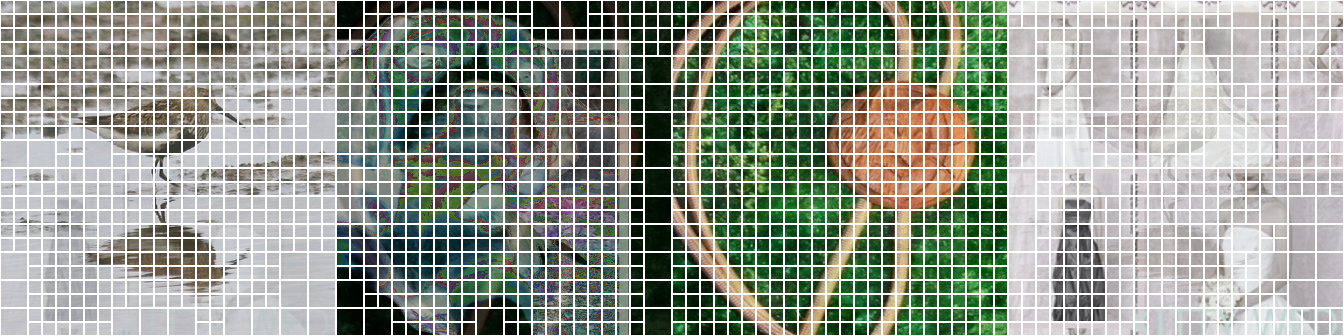

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"
import sys
sys.path.append("..")
import torch
import einops
from dataclasses import dataclass

import numpy as np
from torchvision import transforms
from torchvision.datasets import ImageFolder
from timm.data import Mixup
from torch.utils.data import DataLoader

import PIL.Image as Image

from src.data.transforms import transforms_imagenet_train, transforms_imagenet_eval, ImageFolderWithEntropy
from src.models.entropy_utils import *
from src.models.patch_tokenizer import PatchTokenizer

IMAGE_SIZE = 336
BASE_PATCH_SIZE = 14
NUM_SCALES = 3
THRESHOLDS = [0.0475, 0.03]
BATCH_SIZE = 4

mixup_fn = Mixup(mixup_alpha=0.8, 
                cutmix_alpha=1.0, 
                cutmix_minmax=None,
                prob=1.0, 
                switch_prob=0.5, 
                mode='batch',
                label_smoothing=0.1, 
                num_classes=1000)


unnorm = transforms.Normalize(
    mean=[-0.5/0.5, -0.5/0.5, -0.5/0.5],
    std=[1/0.5, 1/0.5, 1/0.5]
)

@dataclass
class AugmentConfig:
    color_jitter: float = 0.0
    auto_augment: str = 'rand-m9-mstd0.5-inc1'  # RandAugment with magnitude 9
    interpolation: transforms.InterpolationMode = 'bicubic'
    re_prob: float = 0.25  # Random erasing probability
    re_mode: str = 'const'  # Random erasing fill mode ('pixel', 'const', etc.)
    re_count: int = 1  # Number of random erasing regions

# Create an instance to pass to transforms_imagenet_train
augment_config = AugmentConfig()

pre_transform, post_transform = transforms_imagenet_train(
    img_size=IMAGE_SIZE, 
    mean=[0.5, 0.5, 0.5], 
    std=[0.5, 0.5, 0.5],
    pre_post_divide=True,
    augment=augment_config,
)

dataset = ImageFolderWithEntropy(
    root="/edrive1/rchoudhu/ILSVRC2012/val",
    transform=(pre_transform, post_transform),
    patch_size=BASE_PATCH_SIZE,
    num_scales=NUM_SCALES)

dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=0, pin_memory=False, shuffle=True)

tokenizer = PatchTokenizer(
    base_patch_size=BASE_PATCH_SIZE,
    num_scales=NUM_SCALES,
    thresholds=THRESHOLDS,
    image_size=IMAGE_SIZE,
    mean=[0.5, 0.5, 0.5],
    std=[0.5, 0.5, 0.5],
    method="laplacian"
)

# Get one batch. 
print("loading one batch...")
for idx, batch in enumerate(dataloader): 
    if idx > 0: break

print("Done. Processing batch...")
images, labels, entropy_maps = batch

images, labels = mixup_fn(images, labels)

entropy_maps = tokenizer.compute_importance_maps(images)

unnorm = transforms.Normalize(
    mean=[-0.5/0.5, -0.5/0.5, -0.5/0.5],
    std=[1/0.5, 1/0.5, 1/0.5]
)

patch_sizes = entropy_maps.keys()
print("patch sizes: ", patch_sizes)
masks = select_patches_by_threshold(entropy_maps, thresholds=THRESHOLDS)

unnormed_images = unnorm(images)
unnormed_images = (unnormed_images * 255).to(torch.uint8)

print("Running visualization...")
vis_imgs = []
vis_masks = {k: v for k, v in masks.items()}
expected_token_count = (IMAGE_SIZE // BASE_PATCH_SIZE) ** 2
actual_token_counts = []
for batch_idx in range(BATCH_SIZE):
    batch_vis_masks = {k: v[batch_idx] for k, v in vis_masks.items()}
    actual_token_count = sum(v.sum().item() for v in batch_vis_masks.values())
    actual_token_counts.append(actual_token_count)

    print(f"Batch {batch_idx}:")
    print("Expected token number: ", expected_token_count)
    print("Actual token number: ", actual_token_count)
    print("Token fraction: ", actual_token_count / expected_token_count)
    vis_img = visualize_selected_patches_cv2(
        image_tensor=unnormed_images[batch_idx],
        masks=batch_vis_masks,
        patch_sizes=list(patch_sizes),
    )
    vis_imgs.append(np.array(vis_img))

# Concatenate images horizontally
final_vis_img = np.concatenate(vis_imgs, axis=1)
final_vis_img = Image.fromarray(final_vis_img)
final_vis_img


/tmp/ipykernel_2584852/923510304.py:96: UserWarning: Glyph 8310 (\N{SUPERSCRIPT SIX}) missing from font(s) Liberation Sans.
  plt.savefig('vit_accuracy_throughput_final.png', dpi=600, bbox_inches='tight')
/tmp/ipykernel_2584852/923510304.py:97: UserWarning: Glyph 8310 (\N{SUPERSCRIPT SIX}) missing from font(s) Liberation Sans.
  plt.savefig('vit_accuracy_throughput_final.pdf', bbox_inches='tight')
/tmp/ipykernel_2584852/923510304.py:97: UserWarning: Glyph 8310 (\N{SUPERSCRIPT SIX}) missing from font(s) Liberation Sans.
  plt.savefig('vit_accuracy_throughput_final.pdf', bbox_inches='tight')
/usr/local/anaconda3/envs/mixedres2/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8310 (\N{SUPERSCRIPT SIX}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


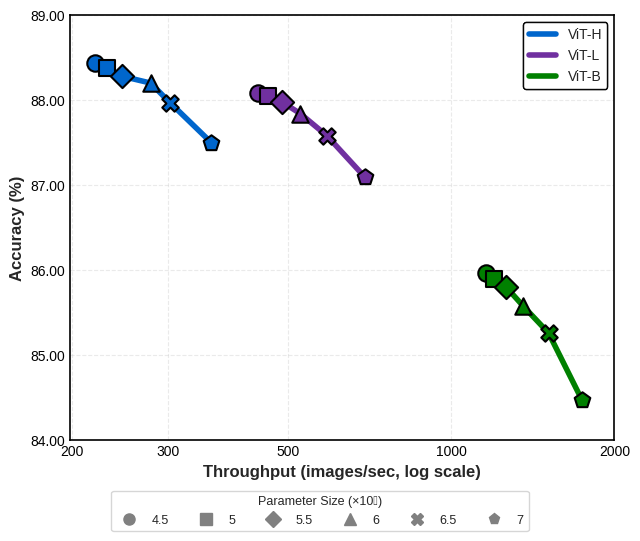

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Data for ViT-H
vit_h_accuracy = [88.44, 88.38, 88.28, 88.20, 87.97, 87.5]
vit_h_throughput = [220, 232, 247, 279, 303, 361]

# Data for ViT-L
vit_l_accuracy = [88.08, 88.05, 87.98, 87.84, 87.58, 87.09]
vit_l_throughput = [440, 460, 487, 527, 590, 694]

# Data for ViT-B
vit_b_accuracy = [85.97, 85.89, 85.80, 85.58, 85.26, 84.47]
vit_b_throughput = [1158, 1198, 1263, 1356, 1512, 1743]

# Parameter sizes
param_sizes = ["4.5", "5", "5.5", "6", "6.5", "7"]

# Define markers for each parameter size
markers = ['o', 's', 'D', '^', 'X', 'p']  # circle, square, diamond, triangle, X, pentagon

# Set up the figure with a size optimized for two-column format
plt.figure(figsize=(6.5, 5))  # Narrower width, better for two-column
plt.style.use('seaborn-v0_8-whitegrid')

# Define bolder, more distinguishable colors
vit_h_color = '#0066CC'  # Darker blue
vit_l_color = '#7030A0'  # Darker purple
vit_b_color = '#008000'  # Darker green

# Plot lines with logarithmic x-axis and thicker lines
plt.semilogx(vit_h_throughput, vit_h_accuracy, '-', color=vit_h_color, linewidth=4, label='ViT-H')
plt.semilogx(vit_l_throughput, vit_l_accuracy, '-', color=vit_l_color, linewidth=4, label='ViT-L')
plt.semilogx(vit_b_throughput, vit_b_accuracy, '-', color=vit_b_color, linewidth=4, label='ViT-B')

# Add points with different markers for each parameter size - slightly smaller now
for i in range(len(param_sizes)):
    # Plot ViT-H points
    plt.scatter(vit_h_throughput[i], vit_h_accuracy[i], s=140, color=vit_h_color, 
                marker=markers[i], edgecolor='black', linewidth=1.5, zorder=3)
    
    # Plot ViT-L points
    plt.scatter(vit_l_throughput[i], vit_l_accuracy[i], s=140, color=vit_l_color, 
                marker=markers[i], edgecolor='black', linewidth=1.5, zorder=3)
    
    # Plot ViT-B points
    plt.scatter(vit_b_throughput[i], vit_b_accuracy[i], s=140, color=vit_b_color, 
                marker=markers[i], edgecolor='black', linewidth=1.5, zorder=3)

# Labels - X axis now includes log indication
plt.xlabel('Throughput (images/sec, log scale)', fontsize=12, fontweight='bold')
plt.ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
# Removed title as requested

# Set axis limits
plt.ylim(84, 89)

# Format y-axis to show two decimal places
plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))

# Add custom x-ticks for better readability on log scale
plt.xticks([200, 300, 500, 1000, 2000], ['200', '300', '500', '1000', '2000'])

# Add grid for better readability but make it less prominent
plt.grid(True, linestyle='--', alpha=0.4)

# Make tick labels and axes darker and more visible
plt.tick_params(axis='both', colors='black', labelsize=10)
for spine in plt.gca().spines.values():
    spine.set_color('black')
    spine.set_linewidth(1.2)

# Create legend for models in upper right
model_legend = plt.legend(fontsize=10, loc='upper right', frameon=True, 
                      framealpha=0.95, edgecolor='black')
plt.gca().add_artist(model_legend)

# Create a more compact parameter size legend below the plot
# Using a horizontal layout to save space
param_handles = [plt.Line2D([0], [0], marker=markers[i], color='gray', 
                        markerfacecolor='gray', markersize=8, linestyle='None') 
                for i in range(len(param_sizes))]
param_labels = [f"{size}" for size in param_sizes]

# Place the parameter legend outside the plot to save space within plot area
plt.figlegend(param_handles, param_labels, 
          loc='upper center', bbox_to_anchor=(0.5, 0.02),
          ncol=6, frameon=True, fontsize=9, title="Parameter Size (×10⁶)", 
          title_fontsize=9)

# Adjust layout - more space at bottom for the legend
plt.subplots_adjust(bottom=0.18)
plt.tight_layout()

# Save the figure in high resolution
plt.savefig('vit_accuracy_throughput_final.png', dpi=600, bbox_inches='tight')
plt.savefig('vit_accuracy_throughput_final.pdf', bbox_inches='tight')

plt.show()